# BI Analyst Case Study: Strategic Lending Acquisition Analysis

## Context

Our company aims to expand its reach within the unbanked and under-banked market by acquiring a strategic lending business. This target company has provided data on their loan disbursements and repayments. Your task is to conduct a comprehensive analysis of this data to evaluate the product's potential and provide actionable recommendations to the leadership team.

## Objectives:

1.	Identify and document the key features of the lending product.
2.	Utilize a Business Intelligence (BI) tool to create visualizations that provide insights into the product's performance.
3.	Define key performance metrics and present their trends using time-series visualizations.
4.	Develop a 3-month profit/loss forecast.
5.	Analyze the company's current credit exposure and risk management strategies.
6.	Recommend appropriate provisioning and write-off thresholds.
7.	Propose portfolio triggers / alerts to mitigate adverse portfolio shifts.
8.	Recommend data-driven changes to the product design and features to enhance profitability and manage credit risk.


## Introduction

The initial stages of the analysis will involve loading necessary packages and loading the data. This will be followed by exploratory analysis to understand the nature of the data. We have two data frames, one partaining to disbursements and another partaining to repayments.

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import os
import datetime as dt

In [ ]:
# We need to connect to postgresSQL and import the tables but for now let me just upload local CSV files

os.chdir('D:\old data\Msc\Resume\interview_tasks\BI_analyst')

disbursements = pd.read_csv('disbursements.csv')
repayments   = pd.read_csv('repayments.csv')

disbursements.head(5)

In [34]:
disbursements.dtypes

customer_id     object
disb_date       object
tenure          object
account_num     object
loan_amount      int64
loan_fee       float64
dtype: object

## Analysis of Disbursements

This table contains information related to each customer, their unique account numbers, the date that they took loans, and the amount of loan they took. This information can help us analyze trends over time by looking at the amounts of loans borrowed within a certain window period. The main methods that will be used to analyse trends are time series analysis methods.

In [112]:
#convert the disbursement date to a proper date column

disbursements['disb_date'] = pd.to_datetime(disbursements['disb_date'])

disbursements.dtypes

customer_id            object
disb_date      datetime64[ns]
tenure                 object
account_num            object
loan_amount             int64
loan_fee              float64
dtype: object

In [114]:
disbursements.head()

,customer_id,disb_date,tenure,account_num,loan_amount,loan_fee
0,91810ca1aa097db79f050f38e9946fa5482b4e28c925e2...,2024-03-19,14 days,3O66YENWELA6E2H1R9YLX0LDZNOMNHD4,360,43.2
1,42ca06e6fe1ff9803e82a5c20184671b54090e488f78d6...,2024-03-19,7 days,6XWHXKKR1W2HIA8I0V75PZFZBXUUGSVO,70,7.0
2,b23747f53af805e18ad16a4ef235b6642d88f9134644ff...,2024-03-19,7 days,OCGK3RJZ91A999VXD4VB3LATPSME3J5L,3500,350.0
3,1bd32f9b083fc6ddfffd65730fbfa66654fa76a19b0b0e...,2024-03-19,14 days,9X3Q682DOR7927IMMJLFHBGP0RP7YF5C,3500,420.0
4,e7cfbaa97ba7702c52df5f1dddba54bd26923ebad945f1...,2024-03-19,7 days,AQH88NNF8S76MGJL4J4ULEAE18O0KLWH,120,12.0


In [116]:
#create a month column

disbursements['disb_month'] = disbursements['disb_date'].dt.month

disbursements.head(5)

,customer_id,disb_date,tenure,account_num,loan_amount,loan_fee,disb_month
0,91810ca1aa097db79f050f38e9946fa5482b4e28c925e2...,2024-03-19,14 days,3O66YENWELA6E2H1R9YLX0LDZNOMNHD4,360,43.2,3
1,42ca06e6fe1ff9803e82a5c20184671b54090e488f78d6...,2024-03-19,7 days,6XWHXKKR1W2HIA8I0V75PZFZBXUUGSVO,70,7.0,3
2,b23747f53af805e18ad16a4ef235b6642d88f9134644ff...,2024-03-19,7 days,OCGK3RJZ91A999VXD4VB3LATPSME3J5L,3500,350.0,3
3,1bd32f9b083fc6ddfffd65730fbfa66654fa76a19b0b0e...,2024-03-19,14 days,9X3Q682DOR7927IMMJLFHBGP0RP7YF5C,3500,420.0,3
4,e7cfbaa97ba7702c52df5f1dddba54bd26923ebad945f1...,2024-03-19,7 days,AQH88NNF8S76MGJL4J4ULEAE18O0KLWH,120,12.0,3


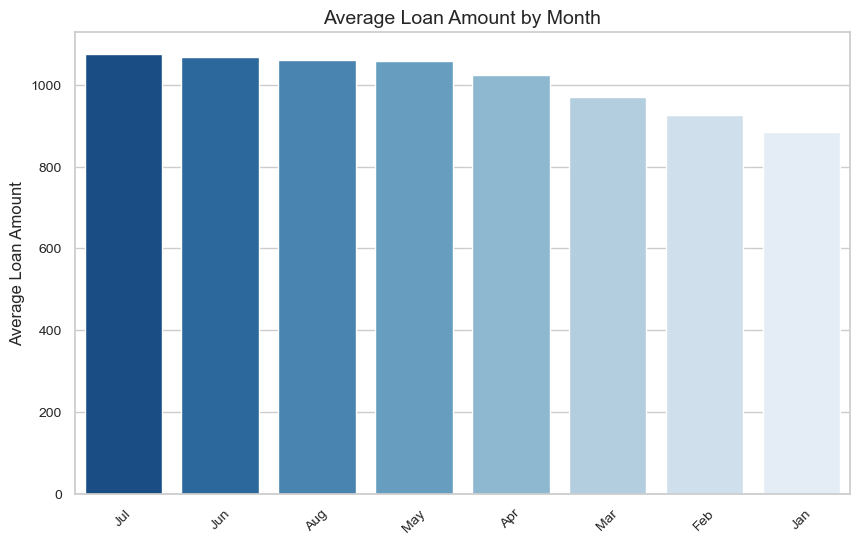

In [132]:
month_labels = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

# Group by month and calculate average loan amount
monthly_avg = disbursements.groupby("disb_month", as_index=False)["loan_amount"].mean()

# Sort in descending order
monthly_avg = monthly_avg.sort_values(by="loan_amount", ascending=False)

# Replace numeric months with month names
monthly_avg["disb_month"] = monthly_avg["disb_month"].map(month_labels)

# Set Seaborn theme for a clean look
sns.set_theme(style="whitegrid")

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="disb_month", y="loan_amount", data=monthly_avg, palette="Blues_r")

# Add labels and title
plt.xlabel("")
plt.ylabel("Average Loan Amount", fontsize=12)
plt.title("Average Loan Amount by Month", fontsize=14)
plt.xticks(rotation=45, fontsize=10)  # Rotate for better readability
plt.yticks(fontsize=10)

# Show the plot
plt.show()


We see that on average the months of April though August had loan amounts of above 1000.

**Time series plot**

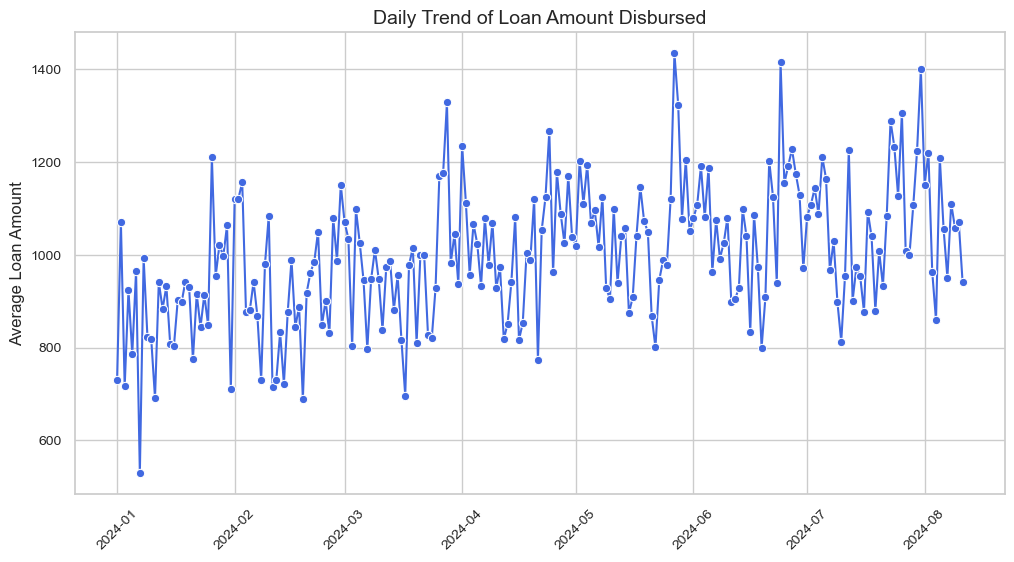

In [152]:
# Aggregate loan amount by date (daily average)
daily_trend = disbursements.groupby("disb_date", as_index=False)["loan_amount"].mean()

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Plot time series
plt.figure(figsize=(12, 6))
sns.lineplot(x="disb_date", y="loan_amount", data=daily_trend, color="royalblue", marker="o")

# Add labels and title
plt.xlabel("", fontsize=12)
plt.ylabel("Average Loan Amount", fontsize=12)
plt.title("Daily Trend of Loan Amount Disbursed", fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Show plot
plt.show()

We need to test for stationarity in the time series. 

The null hypothesis is that the series is not stationary. If the p-value is less than .05 we reject the null hypothesis and conclude that the series is stationary. We will use the Dicky Fuller test for this

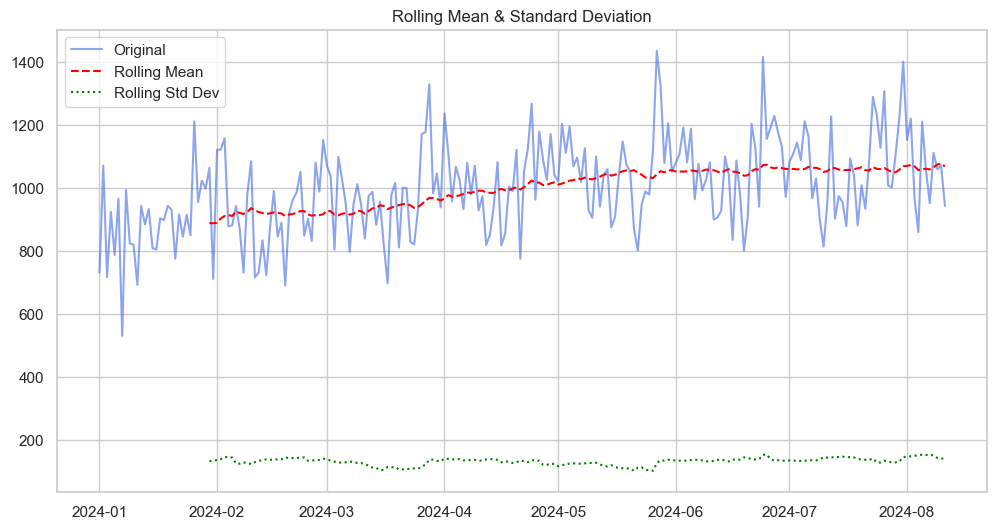

Augmented Dickey-Fuller Test Results:
ADF Statistic: -3.2934
p-value: 0.0152
Critical Values:
   1%: -3.4608
   5%: -2.8750
   10%: -2.5739

✅ The time series is likely stationary (p-value < 0.05).


In [157]:
daily_trend.set_index("disb_date", inplace=True)

# 1️⃣ Plot rolling statistics
plt.figure(figsize=(12, 6))
rolling_mean = daily_trend["loan_amount"].rolling(window=30).mean()
rolling_std = daily_trend["loan_amount"].rolling(window=30).std()

plt.plot(daily_trend, label="Original", color="royalblue", alpha=0.6)
plt.plot(rolling_mean, label="Rolling Mean", color="red", linestyle="dashed")
plt.plot(rolling_std, label="Rolling Std Dev", color="green", linestyle="dotted")
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.show()

# 2️⃣ Perform Augmented Dickey-Fuller Test
adf_result = adfuller(daily_trend["loan_amount"].dropna())

# Print results
print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if adf_result[1] < 0.05:
    print("\n✅ The time series is likely stationary (p-value < 0.05).")
else:
    print("\n❌ The time series is likely non-stationary (p-value >= 0.05).")

Since the series is stationary, we will proceed to modeling without taking any measures like differencing that are used in an attempt to make the series stationary.

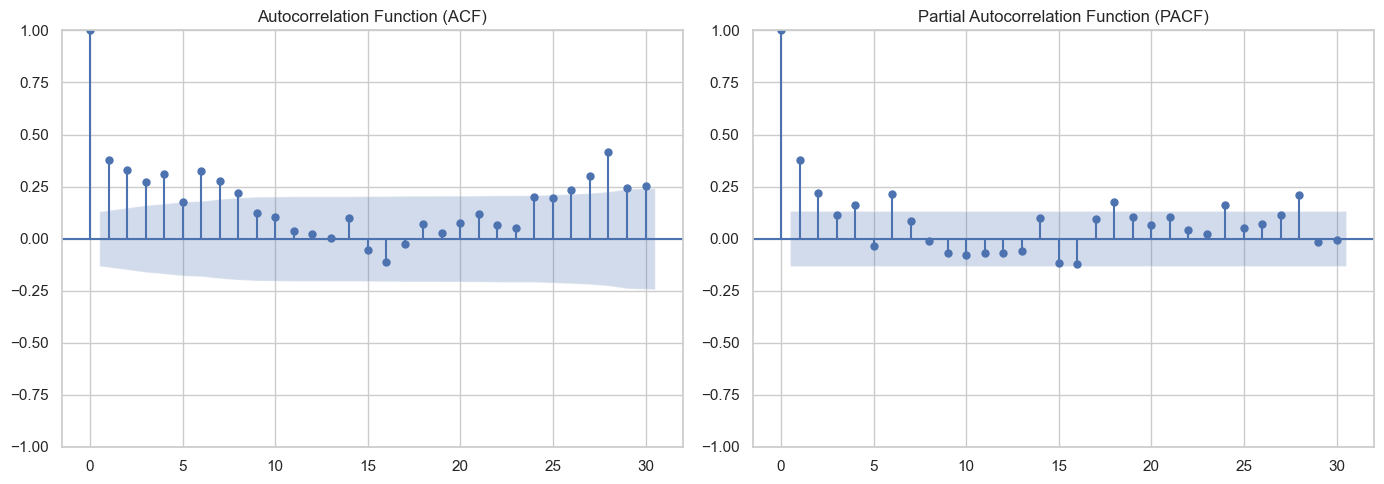

In [160]:
# time series models - ACF and PACF plot to determine the order of correlation

# Set figure size
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot ACF
plot_acf(daily_trend["loan_amount"], lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# Plot PACF
plot_pacf(daily_trend["loan_amount"], lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

The ACF plots helps to check the order for MA - moving average model while the PACF plot helps to check the order of AR - Autoregressive model. In this case looking at the ACF plot we see four significant spikes so we can try an MA(4) model as an initial step.

C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            loan_amount   No. Observations:                  224
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -1411.504
Date:                Thu, 20 Mar 2025   AIC                           2835.007
Time:                        21:17:07   BIC                           2855.477
Sample:                    01-01-2024   HQIC                          2843.270
                         - 08-11-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        998.5913     16.539     60.377      0.000     966.175    1031.007
ma.L1          0.3212      0.070      4.614      0.000       0.185       0.458
ma.L2          0.2311      0.073      3.145      0.0

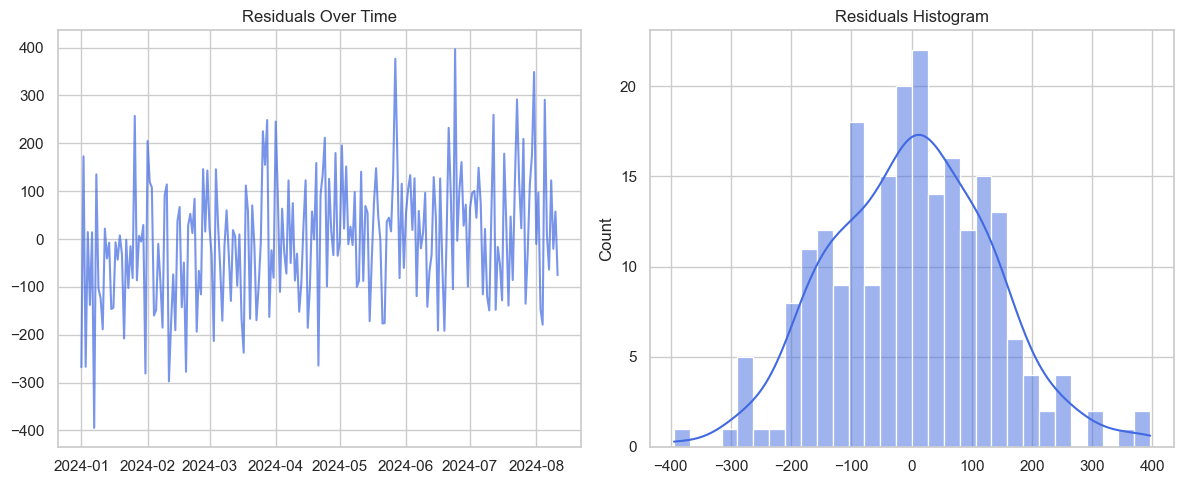

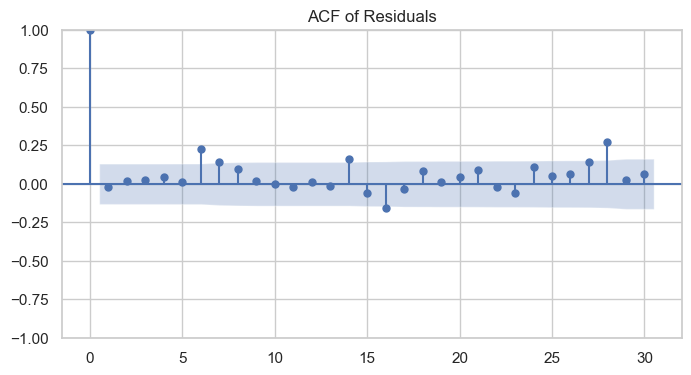

In [173]:
# 2️⃣ Fit an MA(4) model
ma_model = sm.tsa.ARIMA(daily_trend, order=(0, 0, 4))  # (p, d, q) → (0, 0, 4)
ma_result = ma_model.fit()

# Print model summary
print(ma_result.summary())

# 3️⃣ Model Diagnostics: Plot residuals
residuals = ma_result.resid
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Residuals time series plot
axes[0].plot(residuals, color="royalblue", alpha=0.7)
axes[0].set_title("Residuals Over Time")

# Residuals histogram
sns.histplot(residuals, bins=30, kde=True, ax=axes[1], color="royalblue")
axes[1].set_title("Residuals Histogram")

plt.tight_layout()
plt.show()

# 4️⃣ ACF plot of residuals (Check for white noise)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax)
plt.title("ACF of Residuals")
plt.show()